In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


/home/12559743/.local/lib/python3.10/site-packages/pydot.py:17: UserWarning: `pydot` could not import `dot_parser`, so `pydot` will be unable to parse DOT files. The error was:  No module named 'pyparsing'
  warnings.warn(
2024-03-18 18:02:14.340098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 18:02:14.602241: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 18:02:15.406416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory

In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report
from monai.metrics import compute_roc_auc

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-03-18 18:02:27.337597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 18:02:27.515297: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 18:02:28.207974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/Qt/6.3.1/gcc_6/lib:/opt/Qt/6.3.1/gcc_6/lib
2024-03-18 18:02:28.208113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

MONAI version: 1.4.dev2410
Numpy version: 1.23.5
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1e2d41aaa1e494066c8d35fbfae807226cad6227
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.18.3
scipy version: 1.10.1
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1+cu121
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.


In [3]:


directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpojawji_u


In [4]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 0.00B [00:00, ?B/s]

MedNIST.tar.gz: 59.0MB [00:12, 4.77MB/s]                              

2024-03-18 18:02:45,065 - INFO - Downloaded: /tmp/tmpojawji_u/MedNIST.tar.gz


2024-03-18 18:02:45,193 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-18 18:02:45,194 - INFO - Writing into directory: /tmp/tmpojawji_u.


In [5]:
set_determinism(seed=0)

In [6]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")


Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


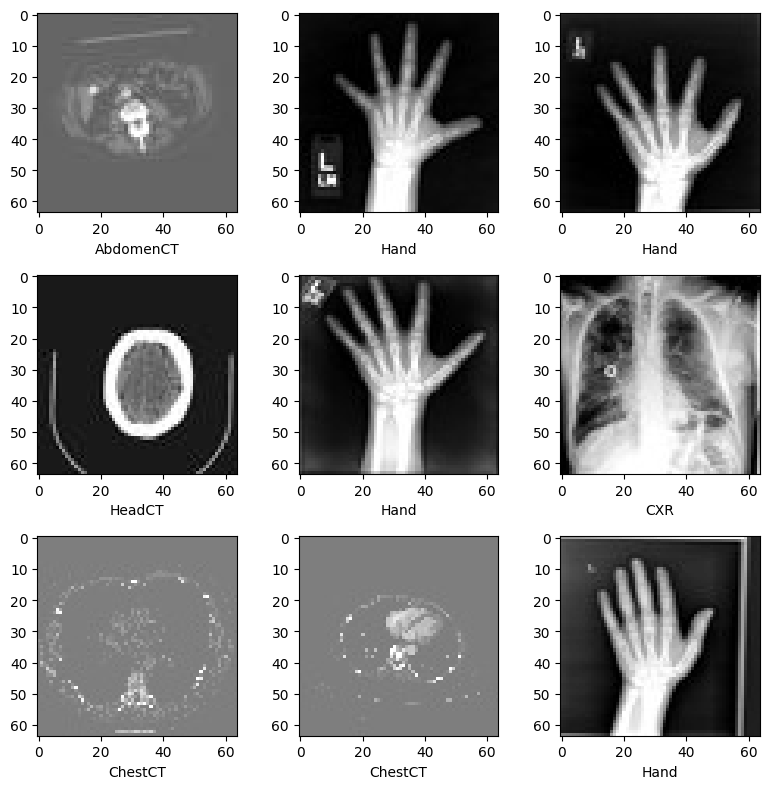

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()


In [8]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


In [9]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])


In [10]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()



In [12]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        prob = histogram
        log_prob = histogram.log()
        plogp = prob*log_prob
        plogp[torch.isnan(plogp)] = 0
        return plogp.sum().detach().cpu().numpy()

    def desiquilibrium(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        histogram = histogram - self.normal_prob()
        return histogram.square().sum().cpu().numpy()

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)


    def normal_prob(self):
        return 1.0/self.bins


def extract_model_data(model, model_data=None):
    if model_data is None:
        model_data = dict()
    c = Complexity()
    for name, param in model.named_parameters():
        if param.requires_grad:
            # we got a valid parameter to extract
            if name not in model_data.keys():
                model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
            model_data[name]['entropy'].append(c.entropy(param.data))
            model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
            model_data[name]['complexity'].append(c.complexity(param.data))
    return model_data


In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

model_data = None
single_complexity = list()
single_loss = list()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

        # EXTRACT MODEL DATA
        model_data = extract_model_data(model, model_data)
        myp = torch.nn.utils.parameters_to_vector(model.parameters())
        single_complexity.append(Complexity().complexity(myp))
        single_loss.append(loss.item())

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result    
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.7884
2/157, train_loss: 1.7585
3/157, train_loss: 1.7380
4/157, train_loss: 1.7221
5/157, train_loss: 1.6796
6/157, train_loss: 1.6535
7/157, train_loss: 1.6342
8/157, train_loss: 1.5934
9/157, train_loss: 1.5791
10/157, train_loss: 1.5626
11/157, train_loss: 1.5248
12/157, train_loss: 1.5101
13/157, train_loss: 1.4798
14/157, train_loss: 1.4446
15/157, train_loss: 1.4480
16/157, train_loss: 1.4279
17/157, train_loss: 1.4058
18/157, train_loss: 1.3708
19/157, train_loss: 1.3487
20/157, train_loss: 1.3251
21/157, train_loss: 1.3262
22/157, train_loss: 1.3010
23/157, train_loss: 1.2990
24/157, train_loss: 1.2837
25/157, train_loss: 1.2604
26/157, train_loss: 1.2657
27/157, train_loss: 1.2018
28/157, train_loss: 1.2153
29/157, train_loss: 1.1672
30/157, train_loss: 1.1647
31/157, train_loss: 1.1561
32/157, train_loss: 1.1363
33/157, train_loss: 1.1436
34/157, train_loss: 1.1043
35/157, train_loss: 1.0892
36/157, train_loss: 1.0873
37/157, train_lo

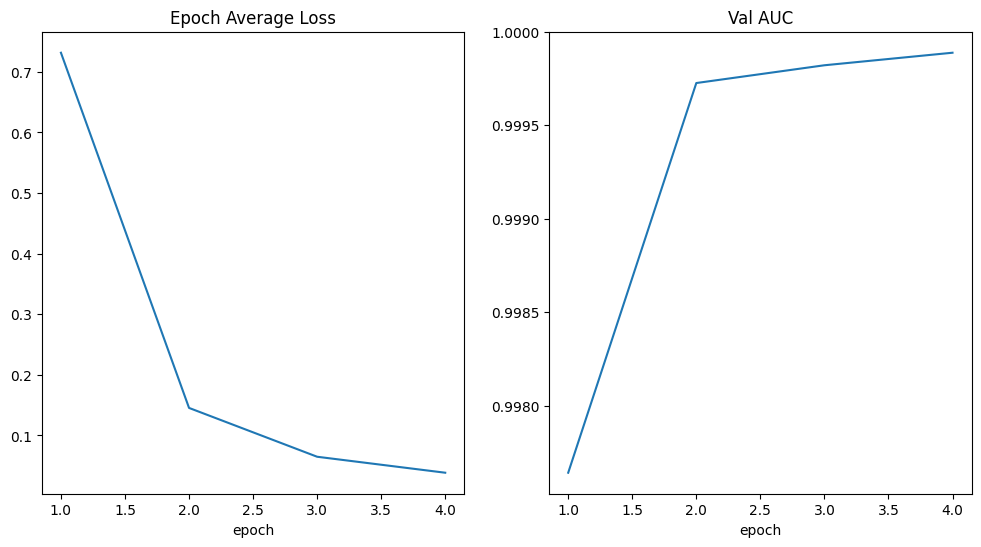

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

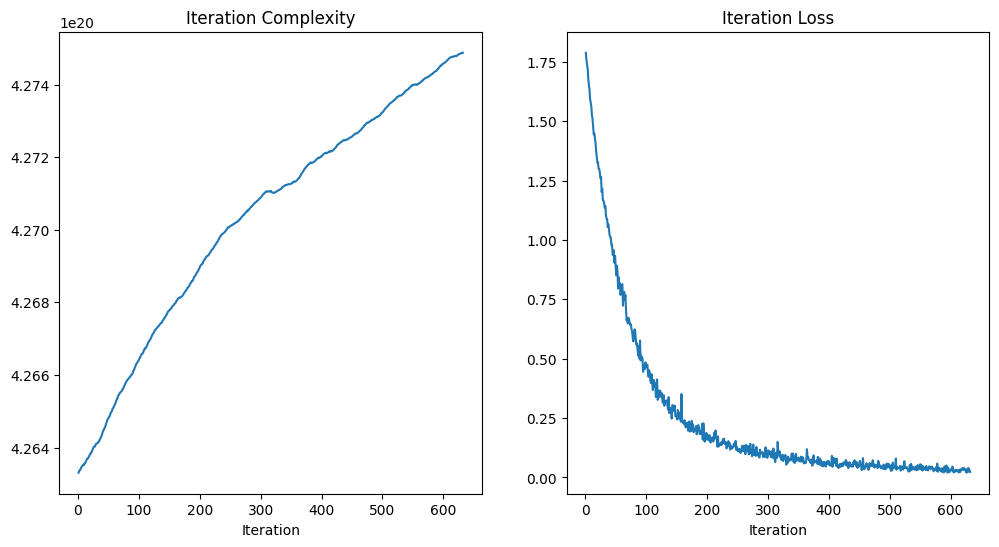

In [15]:
fig = plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Iteration Loss")
x = [val_interval * (i + 1) for i in range(len(single_loss))]
y = single_loss
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()
#fig.savefig('complexity.png')


In [1]:
single_complexity

NameError: name 'single_complexity' is not defined